# Code for Demo Run 

In [3]:
# imports 
import json
import os
import re
import sqlite3
import emoji
import statsmodels

import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from sqlite3 import Error
from datetime import datetime
from tqdm import tqdm
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

In [4]:
# paths to the needed files

db_name = '/Users/alexraudvee/Downloads/tweets_final.db'
convs_path = '/Users/alexraudvee/Downloads/updated_convs.json'

# path to the jsons with easyjet tweets and british airways tweets
easyjet_path = '/Users/alexraudvee/Downloads/easyjet_tweets.json'
british_path = '/Users/alexraudvee/Downloads/britishairways_tweets.json'

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# more paths for hyp test 

db_name = '/Users/alexraudvee/Downloads/tweets_final.db' # loading the data
json_name = "/Users/alexraudvee/Downloads/updated_convs.json"

conv_df = pd.read_json(json_name) 

# avia companies code cell 
avia_companies = {'KLM': 56377143, 'AirFrance': 106062176, 'British_Airways': 18332190, 'AmericanAir': 22536055,
                  'Lufthansa': 124476322, 'AirBerlin': 26223583,
                  'AirBerlin assist': 2182373406, 'easyJet': 38676903, 'RyanAir': 1542862735, 'SingaporeAir': 253340062,
                  'Qantas': 218730857, 'EtihadAirways': 45621423,
                  'VirginAtlantic': 20626359}


# lists with words connected to given topic
comforts = ['seat', 'legroom', 'hotel', 'greed', 'outpricing', 'charged', 'updates', 'website', 'flight experience', 'full price ticket', 'entertainment']
luggages = ['bad', 'luggage', 'baggage', 'handbag', 'belonging', 'suitcase', 'belongings']
punctualitys = ['hour', 'day', 'late', 'waiting', 'delay', 'week', 'home', 'today', 'year', 'tomorrow', 'month', 'morning', 'date', 'night', 'minute', 'queue', 'cancel', 'cancelation', 'flight hour', 'flight tomorrow', 'filght day', 'flight  delay', 'date flight', 'hour delay', 'date flight', 'hour flight', 'return flight', 'flight home', 'flight today', 'week airline', 'flight delay', 'flight week', 'hold hour', 'day flight', 'today flight', 'time flight']
compensations = ['refund', 'money', 'time', 'compensation', 'hold', 'response', 'ticket', 'bill', 'price', 'return', 'refund flight', 'flight refund', 'refund option', 'refund week', 'website refund', 'passenger money', 'tiket fly', 'companion ticket', 'option passenger', 'passenger flight', 'compensation law', 'flight compensation', 'option refund']
customer_service = ['customer', 'service', 'payout', 'phone', 'help', 'someone', 'nothing', 'call', 'fleet', 'board', 'crew', 'ground', 'customer service', 'call centre', 'staff', 'support', 'airline website', 'phone line', 'ground fleet', 'manage booking']
foods = ['food', 'drink', 'snack']
flight_experiences = ['plane', 'flight', 'refund', 'hour', 'staff', 'money', 'support', 'customer', 'back', 'time', 'day', 'plane', 'delay', 'week', 'seat', 'option', 'need', 'compensation', 'company', 'baliouts', 'food', 'help', 'website', 'bag', 'travel', 'bood', 'luggage', 'booking', 'response', 'crew', 'people', 'passanger', 'cancellation', 'cancelation']


# Functions that we use 

In [5]:
def from_Timestamp_to_timestamp_int(Timestamp):
    """
    The input should be: Timestamp(any)
    Returns timestamp integer
    """

    timestamp_int = int(Timestamp.timestamp())

    return timestamp_int


def from_datetime_str_to_timestamp_int(date_str: str):
    """
    The input should be: 'year-mont-day'
    Returns timestamp integer
    """

    date = datetime.strptime(date_str, '%Y-%m-%d')
    timestamp_int = int(date.timestamp())

    return timestamp_int


def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn


def convert(label):
    ddict = {'negative':-1, 'neutral':0, 'positive':1}
    return ddict[label]


def get_margin(a3, df):
    try:
        margin = df[df['alpha_3'] == a3]['tweet_id'].values[0]
    except:
        margin = 0

    return margin



# function for transformation of the dataframe to need format for the plot 
def transformation(df):
    
    df_1 = df.pivot_table(values='tweet_id', index=df.topic, columns='sentiment_label')
    try: 
        df_1['negative'] = df_1[['negative']]
        df_1['neutral'] = df_1[['neutral']].shift(-1)
        df_1['positive'] = df_1[['positive']].shift(-2)
    except:
        df_1['negative'] = pd.DataFrame({'negative':[]})
        df_1['neutral'] = pd.DataFrame({'neutral':[]})
        df_1['positive'] = pd.DataFrame({'positive':[]})

    df_2 = df_1.dropna(how='all').fillna(0).sort_values(by='negative', ascending=False)
    
    return df_2



def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn


def from_Timestamp_to_datetime_str(Timestamp):
    """
    the input should be: Timestamp(any)
    returns date as string: 'year-mont-day'
    """

    date_time = Timestamp.to_pydatetime().strftime('%Y-%m-%d')

    return date_time


def get_change(df):
    # function returns a dictionary with number of each sentiment change for every company
    # 0's say that sentiment between previous and current user's messages hasn't changed, however we distinguished between
    # -0 staying negative, +0 staying positive, 0 staying neitral
    # neg_pos best outcome form previous negative message we got positive response
    # pos_neg worst outcome from previous positive message we got negative response
    #N
    try: 
    
        name = df['reply_to_label'].iloc[0]
        
        stays_positive = df['label_sentiment_diff'].value_counts()['+0']
        stays_negative = df['label_sentiment_diff'].value_counts()['-0']
        stays_neutral = df['label_sentiment_diff'].value_counts()['0']
        
        neg_pos = df['label_sentiment_diff'].value_counts()['neg_pos']
        neu_pos = df['label_sentiment_diff'].value_counts()['neu_pos']
        
        pos_neg = df['label_sentiment_diff'].value_counts()['pos_neg']
        neu_neg = df['label_sentiment_diff'].value_counts()['neu_neg']
        

        improvemnt = stays_positive +  neg_pos + neu_pos

        decline = stays_negative + pos_neg + neu_neg

        sent_change = {"name":name, "neg_pos":neg_pos, "neu_pos": neu_pos, "+0":stays_positive, "0":stays_neutral, 
                      "-0":stays_negative, "neu_neg": neu_neg, "pos_neg":pos_neg, "improvemnt":improvemnt, "decline":decline}

        return sent_change
            
            
    
    except: 
        
        return None
    

def get_list_sample_means(df, response, data_percent, trials): 
    """
    creates the dataframe with sample means of randomly taken samples
    :param df: dataframe from which we take the compound
    :param compound: the compound that we choose 
    :trials: amount of sample means that we will use for ploting the density plot 
    :return: the dataframe of sample means of randomly taken samples 
    """

    # list which will contain the sample means 
    lst_of_means = []

    # creating the array with random samples from the dataframe and adding their means in to the list above
    # argument for using array - we think that array stores faster

    # creating a loop to provide 'trials' amount of random sampling
    n = 0
    while n < trials:
        array_sample = df[[response]].sample(n=int(df[[response]].count()[0]*data_percent), 
                                                  replace=True).reset_index()[response].to_numpy()
        
        lst_of_means.append(np.mean(array_sample))  # add the mean of the sample in the list
        n += 1

    # here we are creating the dataframe which will include our sample means
    df_sample_means = pd.DataFrame({f'{df.index.to_list()[0]}' :lst_of_means})
 
    return df_sample_means

def hyp_testing(df_EJ, df_BA, topics, data_percent, trials):
    

    hyp_test_df = pd.DataFrame()
    
    for topic in topics:
    
        data_EJ_df = df_EJ.set_index('topic').loc[topic][['time_shift']]
        data_BA_df = df_BA.set_index('topic').loc[topic][['time_shift']]

        samples_EJ_df = get_list_sample_means(data_EJ_df, "time_shift", 0.8, 300)
        samples_BA_df = get_list_sample_means(data_BA_df, "time_shift", 0.8, 300)

        normalized_EJ = sm.stats.normal_ad(samples_EJ_df[topic])[1]
        normalized_BA = sm.stats.normal_ad(samples_BA_df[topic])[1]

        t_stat, p_value = stats.ttest_ind(samples_EJ_df[topic], samples_BA_df[topic], equal_var=False, alternative = 'less')

        row = {"topic" : topic, "easyJet_norm" : normalized_EJ, "BritishAirways_norm" : normalized_BA,
               "t_stat": t_stat, "p_value": p_value}


        hyp_test_df = hyp_test_df.append(row, ignore_index=True)
    
    hyp_test_df = hyp_test_df.set_index('topic')

    return(hyp_test_df)


# function for finding the topics in the tweet 

def define_topic(text: str):

    text = text.lower() # convert to lower case 

    if any(word in text for word in comforts):
        return 'comfort'
    elif any(word in text for word in luggages):
        return 'luggage'
    elif any(word in text for word in punctualitys):
        return 'punctuality'
    elif any(word in text for word in compensations):
        return 'compensation'
    elif any(word in text for word in customer_service):
        return 'customer services'
    elif any(word in text for word in foods):
        return 'food'
    elif any(word in text for word in flight_experiences):
        return 'flight exeprience'
    else:
        return None
    

# Slice of the data for given time period 

In [6]:
#####################
select_time_period = True

start_time = '2020-01-01'
end_time = '2020-01-02'
####################

if select_time_period == True:
        
    # convert to timestamps int 
    start_time = from_datetime_str_to_timestamp_int(start_time)
    end_time = from_datetime_str_to_timestamp_int(end_time)

    # convert to the timestamps all the needed variables
    conv_df['timestamp'] = conv_df['timestamp'].apply(lambda row: from_Timestamp_to_timestamp_int(row))

    # slice 
    conv_df = conv_df.loc[(conv_df['timestamp'] >= start_time) & (conv_df['timestamp'] <= end_time)]

# All about GEO and Topics 

In [7]:
countries ={'AW': 'ABW',
 'AF': 'AFG',
 'AO': 'AGO',
 'AI': 'AIA',
 'AX': 'ALA',
 'AL': 'ALB',
 'AD': 'AND',
 'AE': 'ARE',
 'AR': 'ARG',
 'AM': 'ARM',
 'AS': 'ASM',
 'AQ': 'ATA',
 'TF': 'ATF',
 'AG': 'ATG',
 'AU': 'AUS',
 'AT': 'AUT',
 'AZ': 'AZE',
 'BI': 'BDI',
 'BE': 'BEL',
 'BJ': 'BEN',
 'BQ': 'BES',
 'BF': 'BFA',
 'BD': 'BGD',
 'BG': 'BGR',
 'BH': 'BHR',
 'BS': 'BHS',
 'BA': 'BIH',
 'BL': 'BLM',
 'BY': 'BLR',
 'BZ': 'BLZ',
 'BM': 'BMU',
 'BO': 'BOL',
 'BR': 'BRA',
 'BB': 'BRB',
 'BN': 'BRN',
 'BT': 'BTN',
 'BV': 'BVT',
 'BW': 'BWA',
 'CF': 'CAF',
 'CA': 'CAN',
 'CC': 'CCK',
 'CH': 'CHE',
 'CL': 'CHL',
 'CN': 'CHN',
 'CI': 'CIV',
 'CM': 'CMR',
 'CD': 'COD',
 'CG': 'COG',
 'CK': 'COK',
 'CO': 'COL',
 'KM': 'COM',
 'CV': 'CPV',
 'CR': 'CRI',
 'CU': 'CUB',
 'CW': 'CUW',
 'CX': 'CXR',
 'KY': 'CYM',
 'CY': 'CYP',
 'CZ': 'CZE',
 'DE': 'DEU',
 'DJ': 'DJI',
 'DM': 'DMA',
 'DK': 'DNK',
 'DO': 'DOM',
 'DZ': 'DZA',
 'EC': 'ECU',
 'EG': 'EGY',
 'ER': 'ERI',
 'EH': 'ESH',
 'ES': 'ESP',
 'EE': 'EST',
 'ET': 'ETH',
 'FI': 'FIN',
 'FJ': 'FJI',
 'FK': 'FLK',
 'FR': 'FRA',
 'FO': 'FRO',
 'FM': 'FSM',
 'GA': 'GAB',
 'GB': 'GBR',
 'GE': 'GEO',
 'GG': 'GGY',
 'GH': 'GHA',
 'GI': 'GIB',
 'GN': 'GIN',
 'GP': 'GLP',
 'GM': 'GMB',
 'GW': 'GNB',
 'GQ': 'GNQ',
 'GR': 'GRC',
 'GD': 'GRD',
 'GL': 'GRL',
 'GT': 'GTM',
 'GF': 'GUF',
 'GU': 'GUM',
 'GY': 'GUY',
 'HK': 'HKG',
 'HM': 'HMD',
 'HN': 'HND',
 'HR': 'HRV',
 'HT': 'HTI',
 'HU': 'HUN',
 'ID': 'IDN',
 'IM': 'IMN',
 'IN': 'IND',
 'IO': 'IOT',
 'IE': 'IRL',
 'IR': 'IRN',
 'IQ': 'IRQ',
 'IS': 'ISL',
 'IL': 'ISR',
 'IT': 'ITA',
 'JM': 'JAM',
 'JE': 'JEY',
 'JO': 'JOR',
 'JP': 'JPN',
 'KZ': 'KAZ',
 'KE': 'KEN',
 'KG': 'KGZ',
 'KH': 'KHM',
 'KI': 'KIR',
 'KN': 'KNA',
 'KR': 'KOR',
 'KW': 'KWT',
 'LA': 'LAO',
 'LB': 'LBN',
 'LR': 'LBR',
 'LY': 'LBY',
 'LC': 'LCA',
 'LI': 'LIE',
 'LK': 'LKA',
 'LS': 'LSO',
 'LT': 'LTU',
 'LU': 'LUX',
 'LV': 'LVA',
 'MO': 'MAC',
 'MF': 'MAF',
 'MA': 'MAR',
 'MC': 'MCO',
 'MD': 'MDA',
 'MG': 'MDG',
 'MV': 'MDV',
 'MX': 'MEX',
 'MH': 'MHL',
 'MK': 'MKD',
 'ML': 'MLI',
 'MT': 'MLT',
 'MM': 'MMR',
 'ME': 'MNE',
 'MN': 'MNG',
 'MP': 'MNP',
 'MZ': 'MOZ',
 'MR': 'MRT',
 'MS': 'MSR',
 'MQ': 'MTQ',
 'MU': 'MUS',
 'MW': 'MWI',
 'MY': 'MYS',
 'YT': 'MYT',
 'NA': 'NAM',
 'NC': 'NCL',
 'NE': 'NER',
 'NF': 'NFK',
 'NG': 'NGA',
 'NI': 'NIC',
 'NU': 'NIU',
 'NL': 'NLD',
 'NO': 'NOR',
 'NP': 'NPL',
 'NR': 'NRU',
 'NZ': 'NZL',
 'OM': 'OMN',
 'PK': 'PAK',
 'PA': 'PAN',
 'PN': 'PCN',
 'PE': 'PER',
 'PH': 'PHL',
 'PW': 'PLW',
 'PG': 'PNG',
 'PL': 'POL',
 'PR': 'PRI',
 'KP': 'PRK',
 'PT': 'PRT',
 'PY': 'PRY',
 'PS': 'PSE',
 'PF': 'PYF',
 'QA': 'QAT',
 'RE': 'REU',
 'RO': 'ROU',
 'RU': 'RUS',
 'RW': 'RWA',
 'SA': 'SAU',
 'SD': 'SDN',
 'SN': 'SEN',
 'SG': 'SGP',
 'GS': 'SGS',
 'SH': 'SHN',
 'SJ': 'SJM',
 'SB': 'SLB',
 'SL': 'SLE',
 'SV': 'SLV',
 'SM': 'SMR',
 'SO': 'SOM',
 'PM': 'SPM',
 'RS': 'SRB',
 'SS': 'SSD',
 'ST': 'STP',
 'SR': 'SUR',
 'SK': 'SVK',
 'SI': 'SVN',
 'SE': 'SWE',
 'SZ': 'SWZ',
 'SX': 'SXM',
 'SC': 'SYC',
 'SY': 'SYR',
 'TC': 'TCA',
 'TD': 'TCD',
 'TG': 'TGO',
 'TH': 'THA',
 'TJ': 'TJK',
 'TK': 'TKL',
 'TM': 'TKM',
 'TL': 'TLS',
 'TO': 'TON',
 'TT': 'TTO',
 'TN': 'TUN',
 'TR': 'TUR',
 'TV': 'TUV',
 'TW': 'TWN',
 'TZ': 'TZA',
 'UG': 'UGA',
 'UA': 'UKR',
 'UM': 'UMI',
 'UY': 'URY',
 'US': 'USA',
 'UZ': 'UZB',
 'VA': 'VAT',
 'VC': 'VCT',
 'VE': 'VEN',
 'VG': 'VGB',
 'VI': 'VIR',
 'VN': 'VNM',
 'VU': 'VUT',
 'WF': 'WLF',
 'WS': 'WSM',
 'YE': 'YEM',
 'ZA': 'ZAF',
 'ZM': 'ZMB',
 'ZW': 'ZWE'}

avia_companies = {'KLM': 56377143, 'AirFrance': 106062176, 'British_Airways': 18332190, 'AmericanAir': 22536055,
                  'Lufthansa': 124476322, 'AirBerlin': 26223583,
                  'AirBerlin assist': 2182373406, 'easyJet': 38676903, 'RyanAir': 1542862735, 'SingaporeAir': 253340062,
                  'Qantas': 218730857, 'EtihadAirways': 45621423,
                  'VirginAtlantic': 20626359}

exclude_list = avia_companies.values()


# create connection with the database 
conn = create_connection(db_name)

# write query for extracting geo data
query1 = """
    SELECT tweet_geo_id AS tweet_id, country_code
    FROM tweets_geo
"""
# extract geo data
tweet_geo_df = pd.read_sql_query(query1, conn)

# convert jsons to the dataframes 
df_for_easyjet = pd.read_json(easyjet_path)
df_for_britishairways = pd.read_json(british_path)

# convert to normal timestamps
df_for_easyjet['timestamp'] = df_for_easyjet['timestamp_ms_int'].apply(lambda row: from_Timestamp_to_timestamp_int(row))
df_for_britishairways['timestamp'] = df_for_britishairways['timestamp_ms_int'].apply(lambda row: from_Timestamp_to_timestamp_int(row))

if select_time_period == True:
    df_for_easyjet = df_for_easyjet.loc[(df_for_easyjet['timestamp'] >= start_time) & (df_for_easyjet['timestamp'] <= end_time)]
    df_for_britishairways = df_for_britishairways.loc[(df_for_britishairways['timestamp'] >= start_time) & (df_for_britishairways['timestamp'] <= end_time)]

# take only needed info 
df_for_britishairways.drop(['timestamp_ms', 'text', 'sentiment_numeric', 'timestamp_int', 'text_clean_len', 'till_hour_str', 'day_of_year', 'till_minute_str'], axis=1, inplace=True)
df_for_easyjet.drop(['timestamp_ms', 'text', 'sentiment_numeric', 'timestamp_int', 'text_clean_len', 'till_hour_str', 'day_of_year', 'till_minute_str'], axis=1, inplace=True)

# convert to data frames that we are going to use by merging 
df_for_easyjet = pd.merge(df_for_easyjet, tweet_geo_df, on='tweet_id')
df_for_britishairways = pd.merge(df_for_britishairways, tweet_geo_df, on='tweet_id')





# take only negatives 
df_for_easyjet_neg = df_for_easyjet[df_for_easyjet['sentiment_label'] == 'negative']

# take only needed info from the dataframe for the plot 
df_neg_geo_ej = df_for_easyjet_neg[(df_for_easyjet_neg['sentiment_label'] == 'negative') ] 
df_neg_geo_ej.user_id.mask(df_neg_geo_ej.tweet_id.isin(exclude_list),inplace=True)

# group by country code with counted number of negatives tweets
df_neg_geo_ej = df_neg_geo_ej.groupby('country_code').count()[['tweet_id']].reset_index().drop(0)

# eluminate the row with XK because it is not in pandas anymore
df_neg_geo_ej = df_neg_geo_ej[df_neg_geo_ej.country_code != 'XK']

# add the alpha3 instead of the code 
df_neg_geo_ej['alpha_3'] = df_neg_geo_ej['country_code'].apply(lambda x: countries[x])

# df_neg_geo = df_neg_geo[df_neg_geo['tweet_id'] > 20]

# add all them in the world dataframe 
world['margin'] = world['iso_a3'].apply(lambda row: get_margin(row, df_neg_geo_ej))


2.6.0


/Users/alexraudvee/opt/anaconda3/envs/personal_use/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


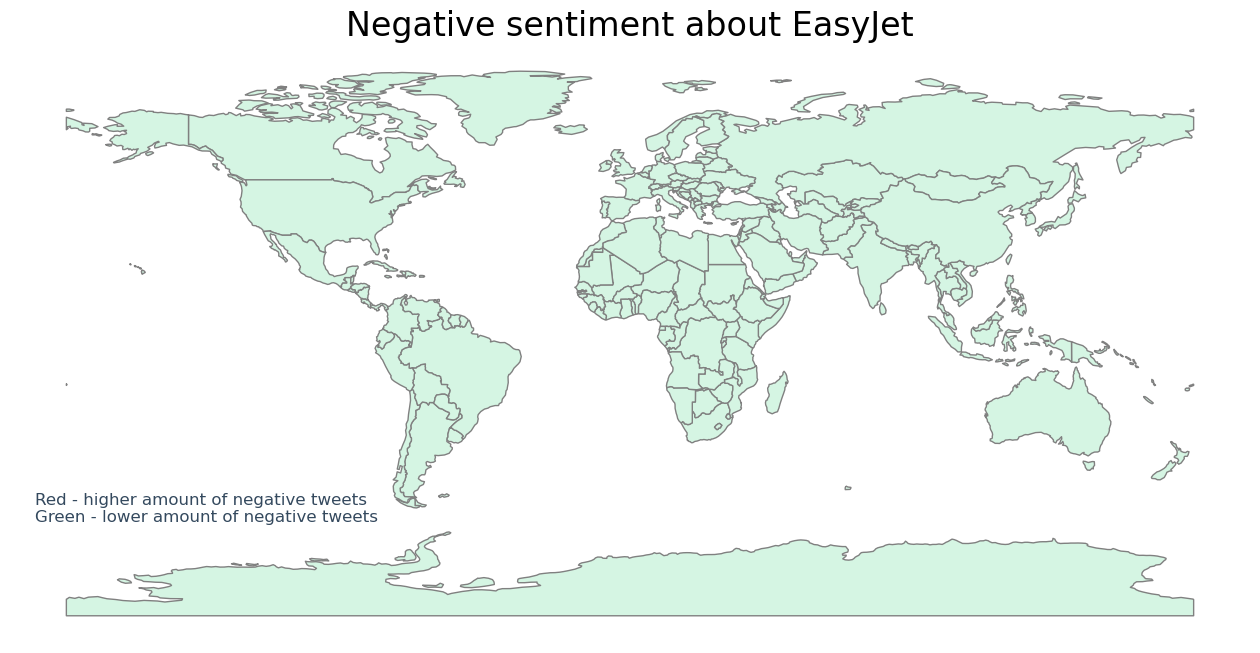

In [8]:
# plot itself 

# create new color map 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',['#D5F5E3', 'red', 'red'], N=256)

ax2 = world.plot(column='margin',  figsize=(16,16), edgecolor=u'gray', cmap=cmap)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.text(x=-190, y=-60, s="""Red - higher amount of negative tweets \nGreen - lower amount of negative tweets""", c='#34495E', size=12)
plt.axis(False)
plt.title('Negative sentiment about EasyJet', size=24)
plt.show()

In [9]:
# take only negatives 
df_for_britishairways_neg = df_for_britishairways[df_for_britishairways['sentiment_label'] == 'negative']

# take only needed info from the dataframe for the plot 
df_neg_geo_ba = df_for_britishairways_neg[(df_for_britishairways_neg['sentiment_label'] == 'negative') ] 
df_neg_geo_ba.user_id.mask(df_neg_geo_ba.tweet_id.isin(exclude_list),inplace=True)

# group by country code with counted number of negatives tweets
df_neg_geo_ba = df_neg_geo_ba.groupby('country_code').count()[['tweet_id']].reset_index().drop(0)

# eluminate the row with XK because it is not in pandas anymore
df_neg_geo_ba = df_neg_geo_ba[df_neg_geo_ba.country_code != 'XK']

# add the alpha3 instead of the code 
df_neg_geo_ba['alpha_3'] = df_neg_geo_ba['country_code'].apply(lambda x: countries[x])

# df_neg_geo = df_neg_geo[df_neg_geo['tweet_id'] > 20]

# add all them in the world dataframe 
world['margin'] = world['iso_a3'].apply(lambda row: get_margin(row, df_neg_geo_ba))

/Users/alexraudvee/opt/anaconda3/envs/personal_use/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


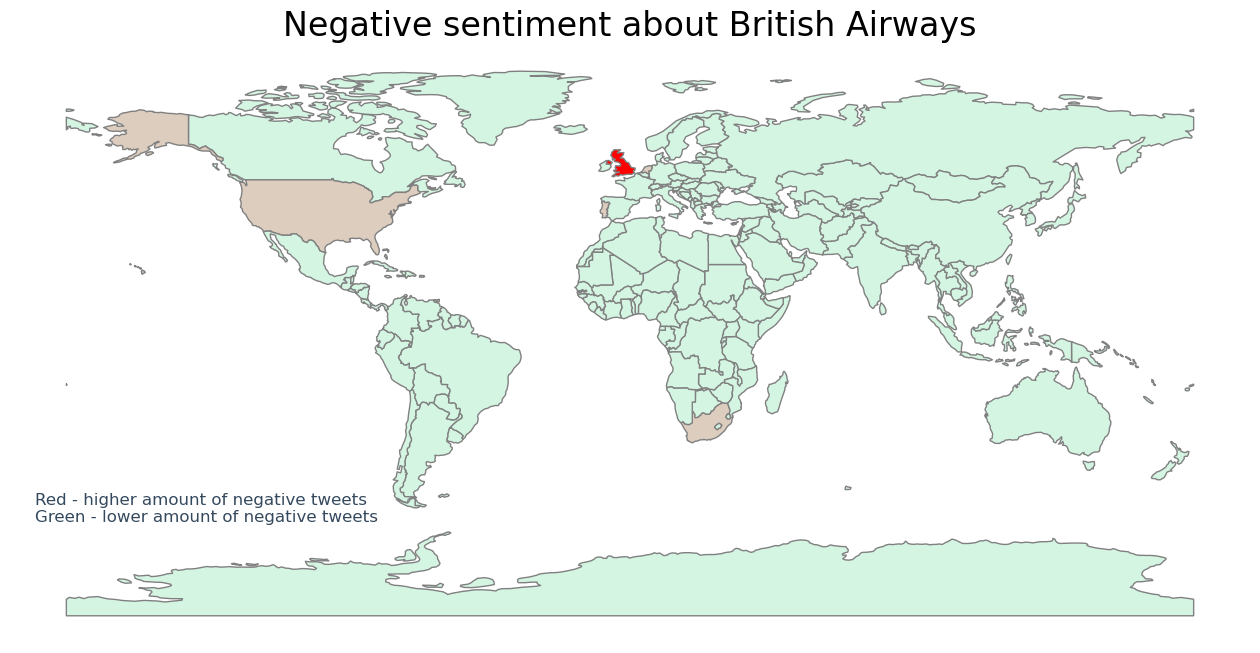

In [10]:
# plot itself 

# create new color map 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',['#D5F5E3', 'red', 'red'], N=256)

ax2 = world.plot(column='margin',  figsize=(16,16), edgecolor=u'gray', cmap=cmap)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.text(x=-190, y=-60, s="""Red - higher amount of negative tweets \nGreen - lower amount of negative tweets""", c='#34495E', size=12)
plt.axis(False)
plt.title('Negative sentiment about British Airways', size=24)
plt.show()

In [19]:
# get the top 5 countries with highest negative tweets as the list of country codes 
df_further_exploration_easy = df_neg_geo_ej.sort_values(by='tweet_id', ascending=False).head(5)
df_further_exploration_british = df_neg_geo_ba.sort_values(by='tweet_id', ascending=False).head(5)
top_country_with_negs = df_further_exploration_easy.country_code.to_frame().reset_index()

# plot itself 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

df_further_exploration_plt_easy = df_further_exploration_easy[['country_code', 'tweet_id']].set_index('country_code')
# plot
try:
    df_further_exploration_plt_easy.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
# title
ax.text(x=0.12, y=.93, s="Top 5 countries with negative tweets about EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

#legend 
ax.legend(['tweets coount'])

# x axis 
ax.set_xlabel('countries')
ax.set_xticks(ticks=[0,1,2,3,4], labels=labels, rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

KeyError: 0

there is no tweets to analyse


Text(0, 0.5, 'Tweets Count')

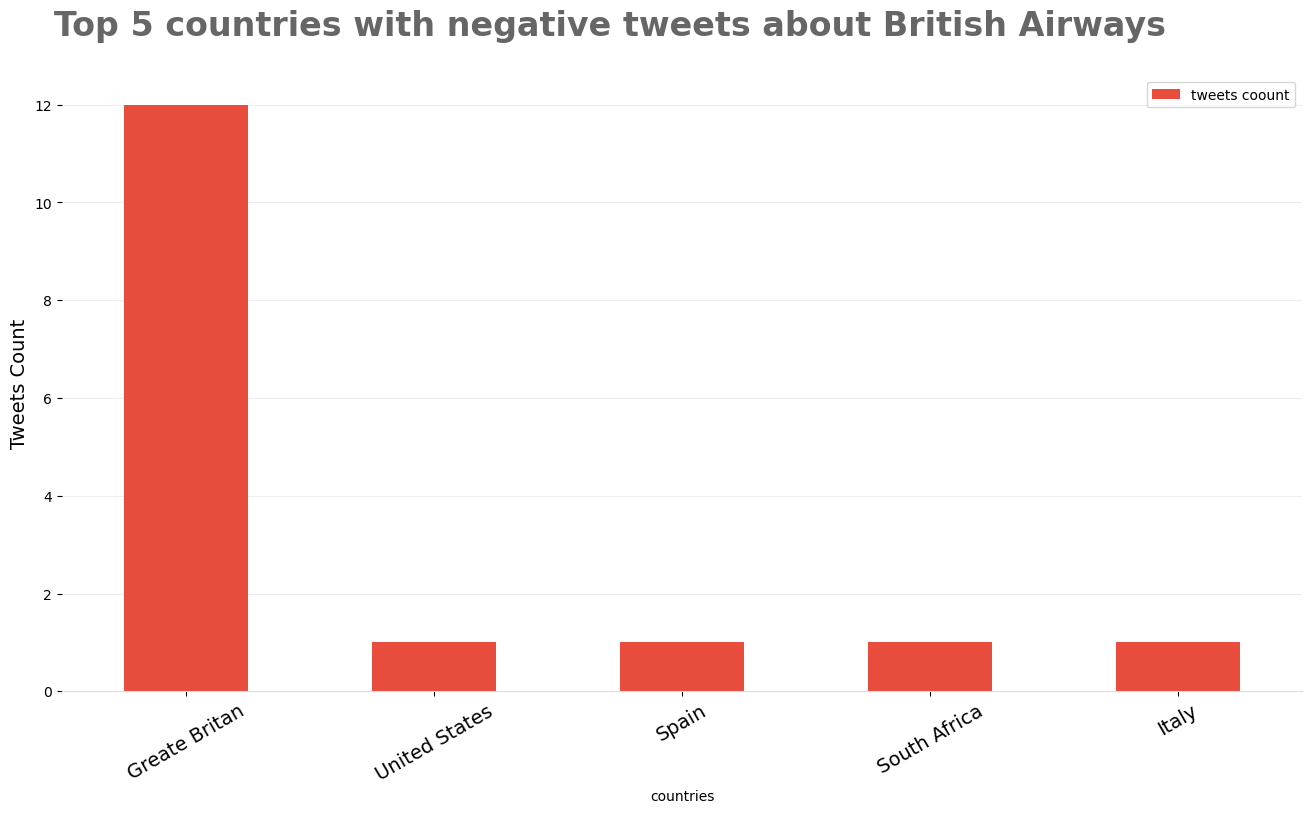

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

df_further_exploration_plt_british = df_further_exploration_british[['country_code', 'tweet_id']].set_index('country_code')
# plot
try:
    df_further_exploration_plt_british.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
# title
ax.text(x=0.12, y=.93, s="Top 5 countries with negative tweets about British Airways", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

#legend 
ax.legend(['tweets coount'])

# x axis 
ax.set_xlabel('countries')
ax.set_xticks(ticks=[0,1,2,3,4], labels=['Greate Britan', 'United States', 'Spain', 'South Africa', 'Italy'], rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

In [25]:
# now prepare the data for topics
df_for_easyjet = pd.merge(df_for_easyjet, top_country_with_negs, on='country_code')
df_for_britishairways = pd.merge(df_for_britishairways, top_country_with_negs, on='country_code')

df_for_easyjet = pd.merge(df_for_easyjet, top_country_with_negs, on='country_code')
df_for_britishairways = pd.merge(df_for_britishairways, top_country_with_negs, on='country_code')    

# adding topics to the dataframe 
df_for_easyjet['topic'] = df_for_easyjet['text_clean'].apply(lambda row: define_topic(row)).dropna()
df_for_britishairways['topic'] = df_for_britishairways['text_clean'].apply(lambda row: define_topic(row)).dropna()

# apply function on different countries EasyJet 
try:
    df_for_topics_easy_GB = transformation(df_for_easyjet[df_for_easyjet['country_code'] == top_country_with_negs['country_code'].loc[0]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
    df_for_topics_easy_ES = transformation(df_for_easyjet[df_for_easyjet['country_code'] == top_country_with_negs['country_code'].loc[1]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
    df_for_topics_easy_FR = transformation(df_for_easyjet[df_for_easyjet['country_code'] == top_country_with_negs['country_code'].loc[2]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
    df_for_topics_easy_IT = transformation(df_for_easyjet[df_for_easyjet['country_code'] == top_country_with_negs['country_code'].loc[3]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
    df_for_topics_easy_DE = transformation(df_for_easyjet[df_for_easyjet['country_code'] == top_country_with_negs['country_code'].loc[4]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
except:
    print('not enough data for valid analys')
# apply function on different countries British Airways
try:
    df_for_topics_british_GB = transformation(df_for_britishairways[df_for_britishairways['country_code'] == top_country_with_negs['country_code'].loc[0]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
except:
    df_for_topics_british_GB = pd.DataFrame({'sentiment_label':[],'negative':[],'neutral':[],'positive':[], 'topic':[]})
try:
    df_for_topics_british_ES = transformation(df_for_britishairways[df_for_britishairways['country_code'] == top_country_with_negs['country_code'].loc[1]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
except:
    df_for_topics_british_ES = pd.DataFrame({'sentiment_label':[],'negative':[],'neutral':[],'positive':[], 'topic':[]})
try:
    df_for_topics_british_FR = transformation(df_for_britishairways[df_for_britishairways['country_code'] == top_country_with_negs['country_code'].loc[2]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
except:
    df_for_topics_british_FR = pd.DataFrame({'sentiment_label':[],'negative':[],'neutral':[],'positive':[], 'topic':[]})
try:
    df_for_topics_british_IT = transformation(df_for_britishairways[df_for_britishairways['country_code'] == top_country_with_negs['country_code'].loc[3]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
except:
    df_for_topics_british_IT = pd.DataFrame({'sentiment_label':[],'negative':[],'neutral':[],'positive':[], 'topic':[]})
try:
    df_for_topics_british_DE = transformation(df_for_britishairways[df_for_britishairways['country_code'] == top_country_with_negs['country_code'].loc[4]].groupby(['topic', 'sentiment_label']).count()[['tweet_id']].reset_index())
except:
    df_for_topics_british_DE = pd.DataFrame({'sentiment_label':[],'negative':[],'neutral':[],'positive':[], 'topic':[]})


not enough data for valid analys


/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/73206855.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_for_easyjet = pd.merge(df_for_easyjet, top_country_with_negs, on='country_code')
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/73206855.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_for_britishairways = pd.merge(df_for_britishairways, top_country_with_negs, on='country_code')


there is no tweets to analyse


Text(0, 0.5, 'Tweets Count')

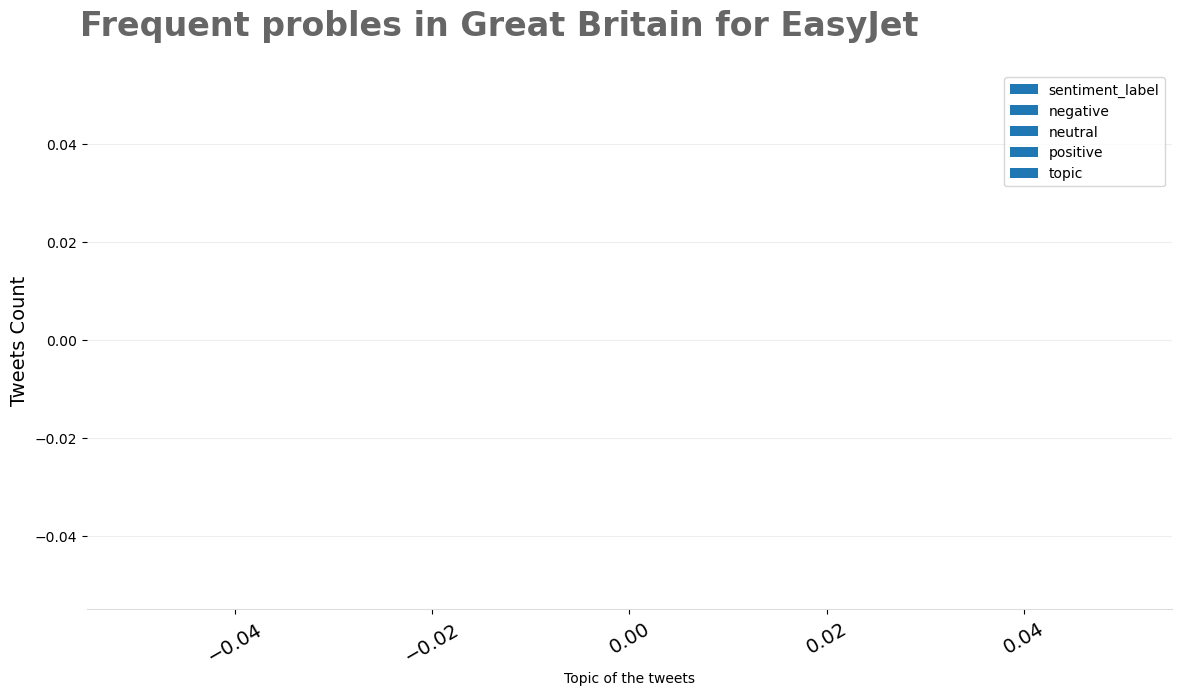

In [26]:
# plot itself
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

# plot
try:
    df_for_topics_british_GB.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
    
# title
ax.text(x=0.12, y=.93, s="Frequent probles in Great Britain for EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# x axis 
ax.set_xlabel('Topic of the tweets')
plt.xticks(rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

there is no tweets to analyse


Text(0, 0.5, 'Tweets Count')

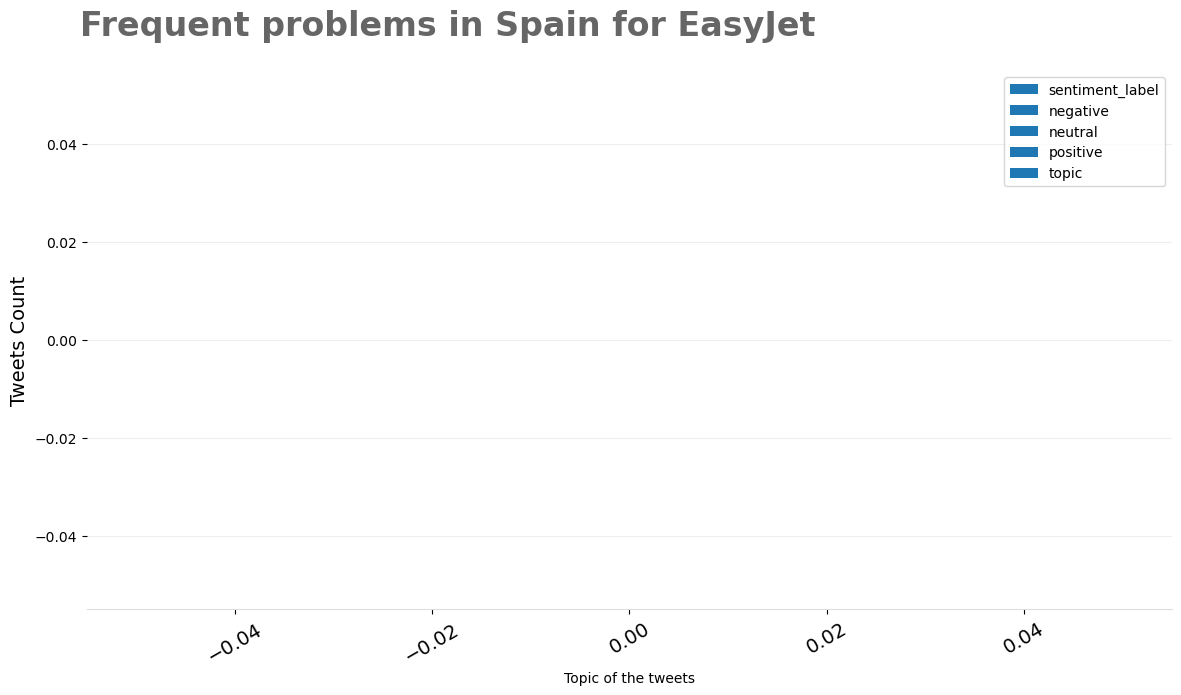

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

# plot
try:
    df_for_topics_british_ES.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
    
# title
ax.text(x=0.12, y=.93, s="Frequent problems in Spain for EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# x axis 
ax.set_xlabel('Topic of the tweets')
plt.xticks(rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

there is no tweets to analyse


Text(0, 0.5, 'Tweets Count')

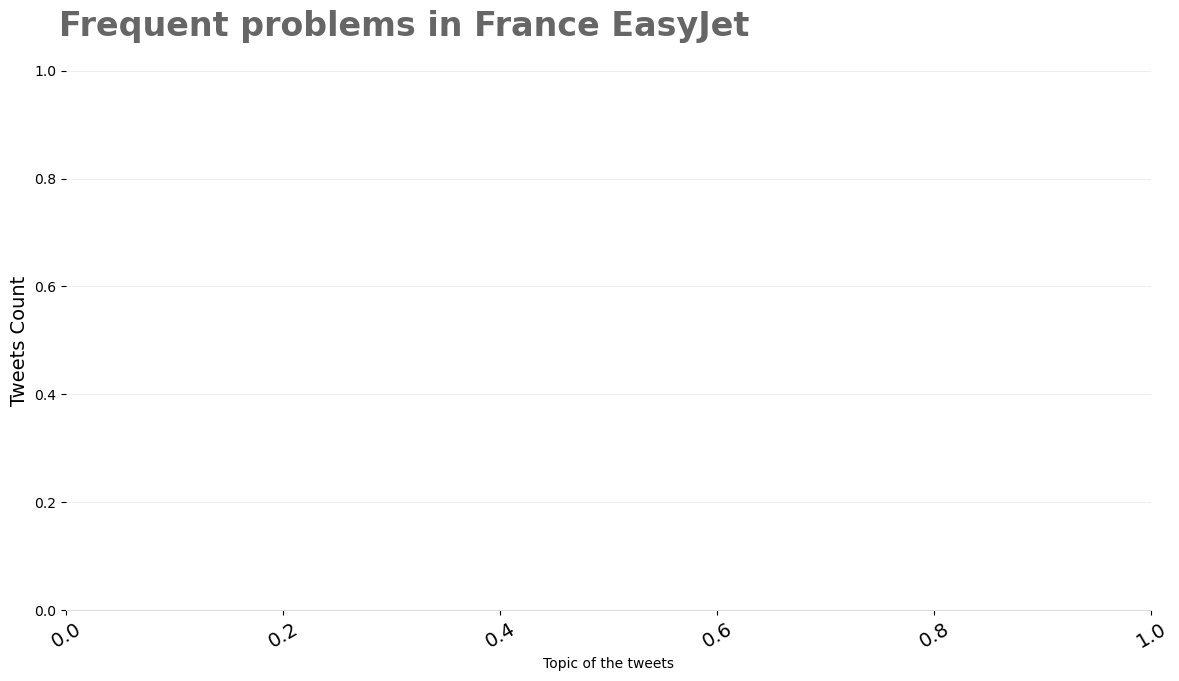

In [28]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

# plot
try:
    df_for_topics_easy_FR.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
    
# title
ax.text(x=0.12, y=.93, s="Frequent problems in France EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# x axis 
ax.set_xlabel('Topic of the tweets')
plt.xticks(rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

there is no tweets to analyse


Text(0, 0.5, 'Tweets Count')

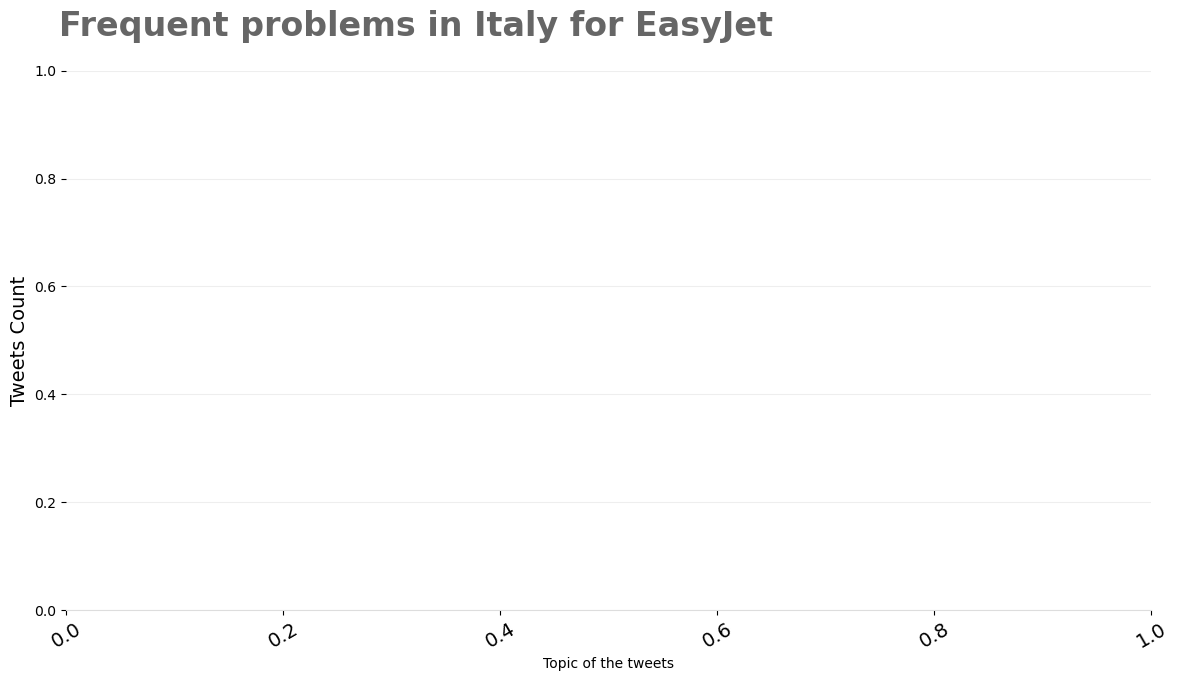

In [29]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

# plot
try:
    df_for_topics_easy_IT.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
    
# title
ax.text(x=0.12, y=.93, s="Frequent problems in Italy for EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# x axis 
ax.set_xlabel('Topic of the tweets')
plt.xticks(rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

there is no tweets to analyse


Text(0, 0.5, 'Tweets Count')

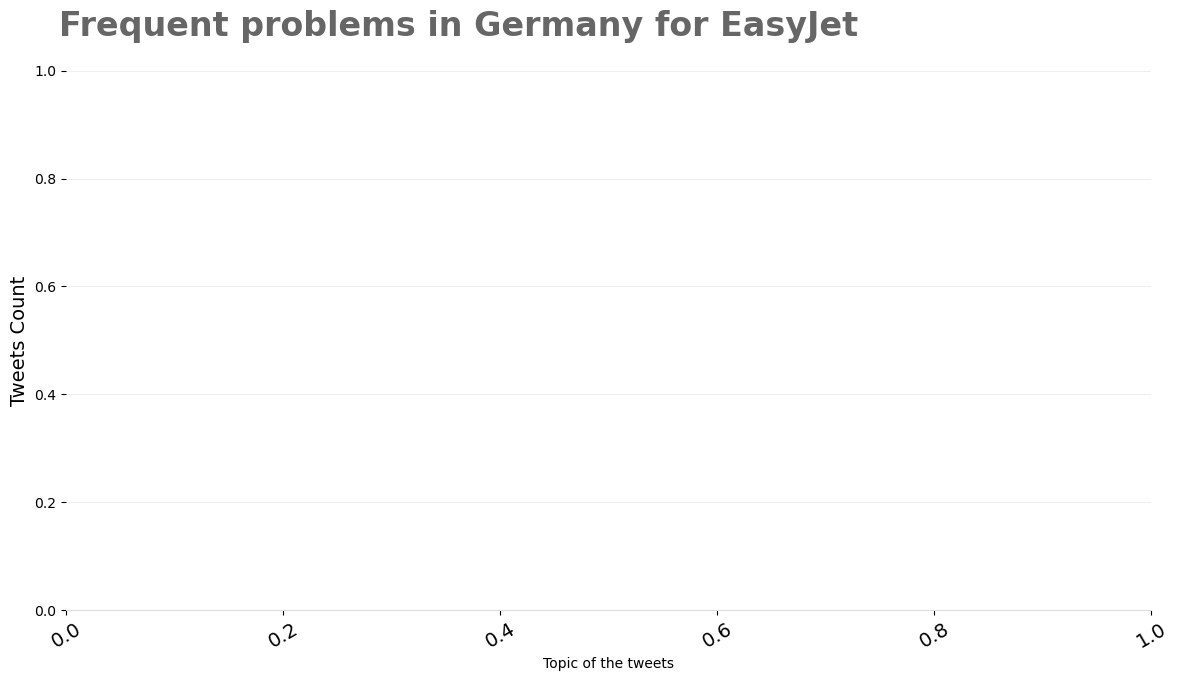

In [30]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

# plot
try:
    df_for_topics_easy_DE.plot(kind='bar', ax=ax, color=['#E74C3C'])
    labels = [top_country_with_negs['country_code'].loc[0], 
          top_country_with_negs['country_code'].loc[1], 
          top_country_with_negs['country_code'].loc[2],
          top_country_with_negs['country_code'].loc[3],
          top_country_with_negs['country_code'].loc[4]]
except:
    labels = []
    print('there is no tweets to analyse')
    
# title
ax.text(x=0.12, y=.93, s="Frequent problems in Germany for EasyJet", transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)


# x axis 
ax.set_xlabel('Topic of the tweets')
plt.xticks(rotation=30, size=14)

# y axis 
ax.set_ylabel('Tweets Count', size=14)

In [32]:
# combine all tweets from all countries
try:
    df_easy_jet_all = pd.concat([df_for_topics_easy_DE, df_for_topics_easy_ES, df_for_topics_easy_FR, df_for_topics_easy_GB, df_for_topics_easy_IT]).groupby(['topic']).sum().sort_values(by='negative', ascending=False)
    df_british_jet_all = pd.concat([df_for_topics_british_DE, df_for_topics_british_ES, df_for_topics_british_FR, df_for_topics_british_GB, df_for_topics_british_IT]).groupby(['topic']).sum().sort_values(by='negative', ascending=False)
except:
    print('not enough data for valid analysis')

not enough data for valid analysis


NameError: name 'df_british_jet_all' is not defined

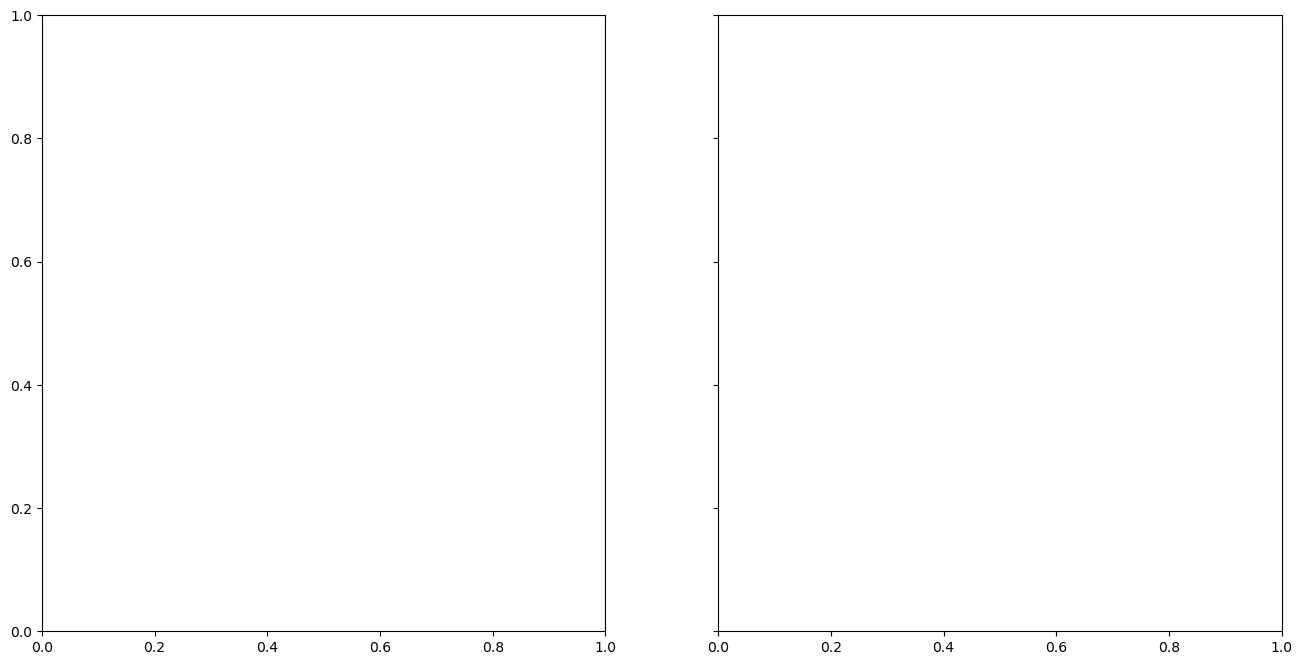

In [37]:
# initialize the figure for the plots 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharey=True)

# plots
bars_grouped1 = df_british_jet_all.plot(kind='bar', ax=ax[0], color=['#E74C3C', '#AAB7B8', '#2ECC71'])
bars_grouped2 = df_easy_jet_all.plot(kind='bar', ax=ax[1], color=['#E74C3C', '#AAB7B8', '#2ECC71'])

# title
fig.text(x=0.32, y=.93, s="Sentiment About Certain Topic", transform=fig.transFigure, ha='left', fontsize=28, weight='bold', alpha=.6)

fig.text(x=0.45, y=0, s="Problems with ...", transform=fig.transFigure, ha='left', fontsize=13, alpha=.9, weight='bold')

# set suptite
ax[0].set_title('British Airways')
ax[1].set_title('EasyJet')

# Axis formatting.
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_color('#DDDDDD')
ax[1].spines['bottom'].set_color('#DDDDDD')
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[0].yaxis.grid(True, color='#EEEEEE')
ax[1].yaxis.grid(True, color='#EEEEEE')
ax[0].xaxis.grid(False)
ax[1].xaxis.grid(False)


# x axis 
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].tick_params(labelrotation=30)
ax[1].tick_params(labelrotation=30)

# y axis 
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_ylabel('Number Of Tweets', size=14)

# saving code
# fig.get_figure().savefig('sentiment_about_topics.png')

# All about conversations 

In [38]:
reverse_avia_companies={}
for key in avia_companies.keys():
    reverse_avia_companies[avia_companies[key]]=key


# connect to the database 
try:
     
    # Making a connection between sqlite3
    # database and Python Program
    sqliteConnection = sqlite3.connect(db_name)
     
    # If sqlite3 makes a connection with python
    # program then it will print "Connected to SQLite"
    # Otherwise it will show errors
    print("Connected to SQLite")
 
    # Getting all tables from sqlite_master
    sql_query = """SELECT name FROM sqlite_master
    WHERE type='table';"""
 
    # Creating cursor object using connection object
    cursor = sqliteConnection.cursor()
     
    # executing our sql query
    cursor.execute(sql_query)
    print("List of tables\n")
     
    # printing all tables list
    print(cursor.fetchall())
 
except sqlite3.Error as error:
    print("Failed to execute the above query", error)
     
finally:
   
    # Inside Finally Block, If connection is
    # open, we need to close it
    if sqliteConnection:
         
        # using close() method, we will close
        # the connection
        sqliteConnection.close()
         
        # After closing connection object, we
        # will print "the sqlite connection is
        # closed"
        print("the sqlite connection is closed")


# connection 
cnx = create_connection(db_name)

conv_len = {}
for conv_id in conv_df['conv_id']:
    conv_len[conv_id] = conv_len.get(conv_id, 0) + 1

used_id_lst = [] # list with all ids used for response anaalysis
for key in conv_len.keys():
    if conv_len[key] > 2:
        used_id_lst.append(key)
    
    
intresting = (len(conv_len), len(conv_len) - len(used_id_lst), len(used_id_lst)) 
# first value =  number of all coversations
# third value = number of all conversations with only to messages
# thirs value = number of convesations that have more than 2 meassgaes

used_df = pd.DataFrame() # data frem with all necesary data for conversation and response time analysis
                         # a backbone of this part of code
    

used_df = used_df.append(conv_df[conv_df['conv_id'].isin(used_id_lst)])


conv_len_check = {}
for conv_id in used_df['conv_id']:
    conv_len_check[conv_id] = conv_len.get(conv_id, 0) + 1

# len(conv_len_check.keys()) # just double checking if everything works

c_first = [] # list with converstion ids where company starts 
u_first = [] # list with converstion ids where user starts 

for index, rows in used_df[used_df['time_taken'] == 0].iterrows():
    if rows['user_id'] in list(avia_companies.values()):
        c_first.append(rows['conv_id'])
    else:
        u_first.append(rows['conv_id'])
    
# DIFFERENCE IN SENTIMENT IN CONVERSATIONS 
userf_diff_df = pd.DataFrame()
compf_diff_df = pd.DataFrame()

userf_diff_df = userf_diff_df.append(used_df[used_df['conv_id'].isin(u_first)])
compf_diff_df = compf_diff_df.append(used_df[used_df['conv_id'].isin(c_first)])


userf_diff_df['time_shift'] = userf_diff_df['time_taken'].shift(1)

userf_diff_df.drop(userf_diff_df[userf_diff_df['time_taken'] == 0].index, inplace = True)

userf_diff_df.drop(userf_diff_df[userf_diff_df['user_id'].isin(list(avia_companies.values()))].index, inplace = True)

compf_diff_df['time_shift'] = compf_diff_df['time_taken'].shift(1)

compf_diff_df.drop(compf_diff_df[compf_diff_df['user_id'].isin(list(avia_companies.values()))].index, inplace = True)

compf_diff_df.drop(compf_diff_df[compf_diff_df['time_shift'] == 0].index, inplace = True)

users_resp_df = pd.concat([compf_diff_df,userf_diff_df])

merged_diff_df = users_resp_df

def getting_company(ids):
    label = reverse_avia_companies[ids]
    return(label)

# merged_diff_df['reply_to_label'] = merged_diff_df['reply_to_user_id'].apply(getting_company)
merged_diff_df['reply_to_label'] = merged_diff_df['for_airline_id'].apply(getting_company)

merged_diff_df['label_sentiment_diff'] = '' # we label sentiment diffrence score, because it makes it easier to work with


for index, row in merged_diff_df.iterrows():
    if row['sentiment_diff'] == 0 and row['sentiment_label'] == 'positive':
        merged_diff_df.at[index, 'label_sentiment_diff'] = "+0"
        
    if row['sentiment_diff'] == 0 and row['sentiment_label'] == 'negative':
        merged_diff_df.at[index, 'label_sentiment_diff'] = "-0"
        
    if row['sentiment_diff'] == 0 and row['sentiment_label'] == 'neutral':
        merged_diff_df.at[index, 'label_sentiment_diff'] = "0"
        
    if row['sentiment_diff'] == 2:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "neg_pos"
        
    if row['sentiment_diff'] == -2:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "pos_neg"

    if row['sentiment_diff'] == 1:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "neu_pos"
        
    if row['sentiment_diff'] == -1:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "neu_neg"

merged_diff_df.groupby(['reply_to_label','label_sentiment_diff'])['tweet_id'].count()

# data frame with users responses to AirFrance
AirFrance_df = pd.DataFrame()

AirFrance_df = AirFrance_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'AirFrance'])

# data frame with users responses to AmericanAir
AmericanAir_df = pd.DataFrame()

AmericanAir_df = AmericanAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'AmericanAir'])

# data frame with users responses to British_Airways
BritishAirways_df = pd.DataFrame()

BritishAirways_df = BritishAirways_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'British_Airways'])

# data frame with users responses to EtihadAirways
EtihadAirways_df = pd.DataFrame()

EtihadAirways_df = EtihadAirways_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'EtihadAirways'])

# data frame with users responses to KLM
KLM_df = pd.DataFrame()

KLM_df = KLM_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'KLM'])

# data frame with users responses to Lufthansa
Lufthansa_df = pd.DataFrame()

Lufthansa_df = Lufthansa_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'Lufthansa'])

# data frame with users responses to Qantas
Qantas_df = pd.DataFrame()

Qantas_df = Qantas_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'Qantas'])

# data frame with users responses to RyanAir
RyanAir_df = pd.DataFrame()

RyanAir_df = RyanAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'RyanAir'])

# data frame with users responses to SingaporeAir
SingaporeAir_df = pd.DataFrame()

SingaporeAir_df = SingaporeAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'SingaporeAir'])

# data frame with users responses to VirginAtlantic
VirginAtlantic_df = pd.DataFrame()

VirginAtlantic_df = VirginAtlantic_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'VirginAtlantic'])

# data frame with users responses to easyJet
easyJet_df = pd.DataFrame()

easyJet_df = easyJet_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'easyJet'])

eureka = merged_diff_df.groupby(['reply_to_label', 'label_sentiment_diff'])[['label_sentiment_diff']].count()

AirFrance_df.groupby(['label_sentiment_diff']).count()



# generate the random samples 
random = pd.DataFrame()


responses_lst = [AirFrance_df, AmericanAir_df, 
                 BritishAirways_df, EtihadAirways_df,
                KLM_df, Lufthansa_df, Qantas_df, RyanAir_df,
                SingaporeAir_df, VirginAtlantic_df, easyJet_df, random]

responses_analysis = pd.DataFrame()

for company in responses_lst:
    row = get_change(company)
    responses_analysis = responses_analysis.append(row, ignore_index=True)

responses_analysis = responses_analysis.set_index('name')

# responses_analysis = responses_analysis.set_index('name')
df_col = ['neg_pos', 'neu_pos', '+0','0', '-0', 'neu_neg', 'pos_neg', 'improvemnt', 'decline']
responses_analysis = responses_analysis[df_col]

Connected to SQLite
List of tables

[('users',), ('tweets',), ('tweets_geo',), ('replies',), ('retweets',), ('quotes',), ('hashtags',), ('sqlite_sequence',), ('symbols',), ('user_mentions',), ('urls',)]
the sqlite connection is closed
2.6.0


/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1788455031.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  used_df = used_df.append(conv_df[conv_df['conv_id'].isin(used_id_lst)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1788455031.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  userf_diff_df = userf_diff_df.append(used_df[used_df['conv_id'].isin(u_first)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1788455031.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compf_diff_df = compf_diff_df.append(used_df[used_df['conv_id'].isin(c_first)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1788455031.py:152: FutureWarning: The frame.appen

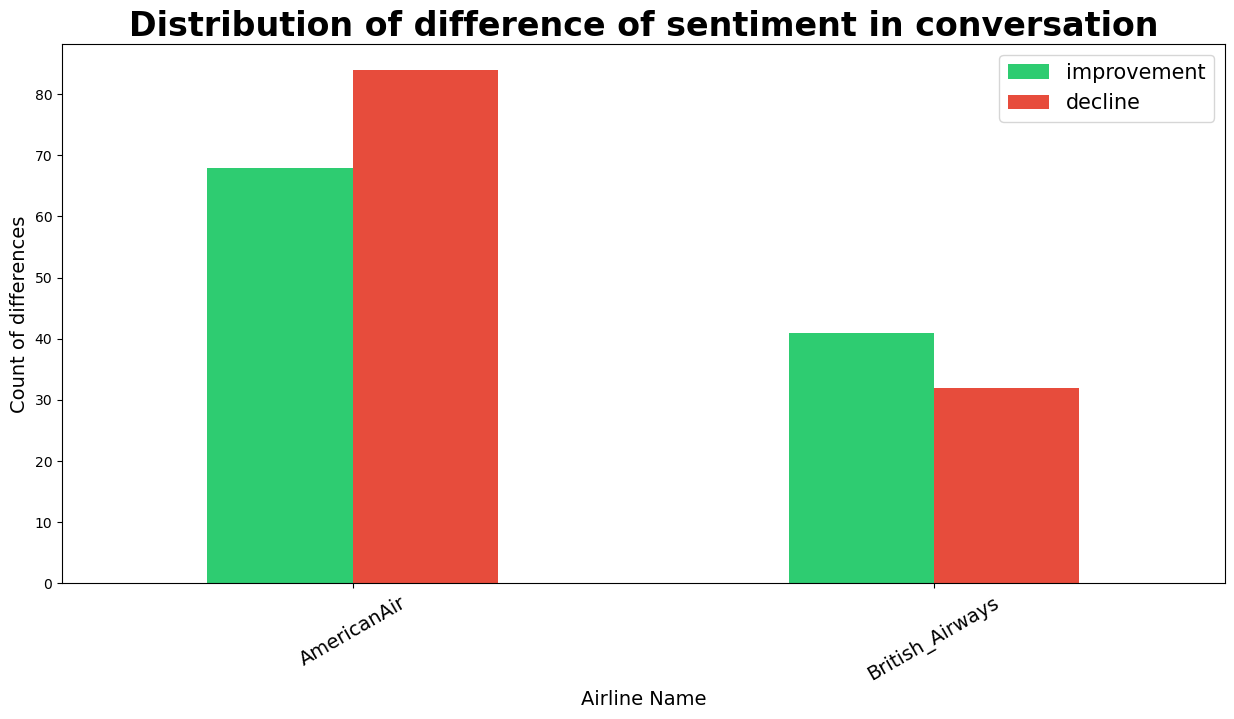

In [39]:
# visualisation of sentiment change per company

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))


bars_grouped = responses_analysis[['improvemnt', 'decline']].sort_values(by = "decline", ascending = False).plot(kind='bar', 
                                                                  ax=ax, color=["#2ECC71", '#E74C3C'])

plt.title("Distribution of difference of sentiment in conversation", size = 24, weight='bold')
# ax.text(x=0.12, y=.93, s="Distribution of difference of sentiment in conversation", 
#         transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# x axis 
ax.set_xlabel('Airline Name', size = 14)
plt.xticks(rotation=30, size=14)
plt.legend(["improvement", "decline"], prop = { "size": 15 }, loc ="upper right")

# y axis 
ax.set_ylabel('Count of differences', size=14);

# code for saving
#fig.get_figure().savefig('dist_of_sent_per_airline.png')

No tweets about EasyJet or British Airways


IndexError: index 0 is out of bounds for axis 0 with size 0

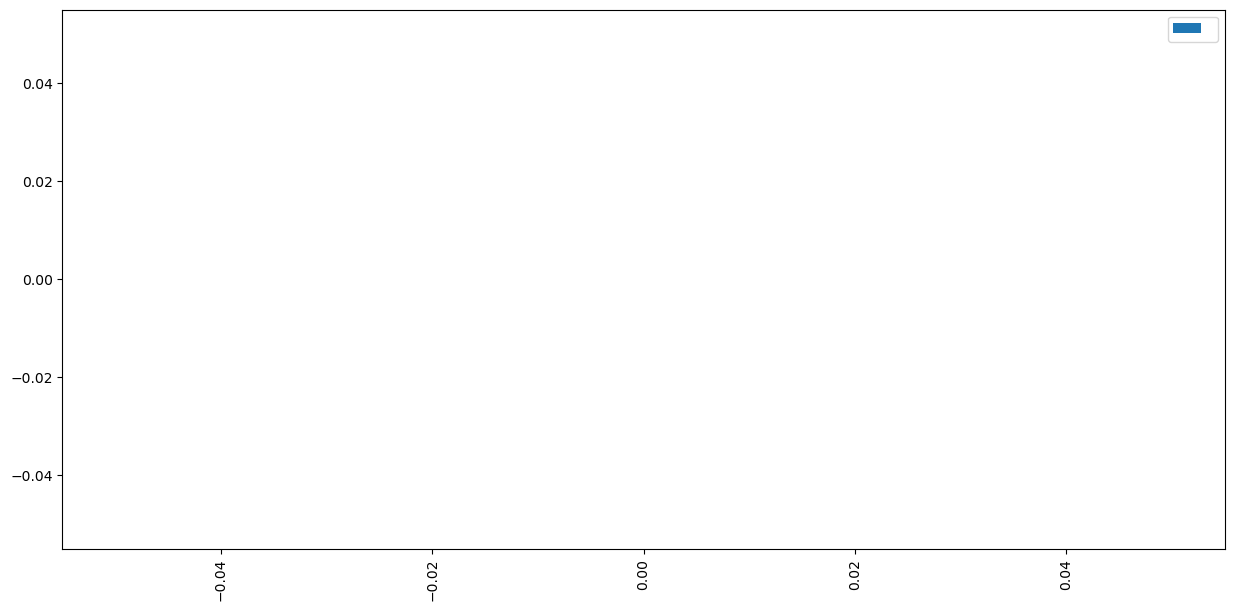

In [49]:
try:
    AE_BA_df = responses_analysis.loc[['easyJet', 'British_Airways']]
except:
    print('No tweets about EasyJet or British Airways')
color = ["#27AE60", "#58D68D", "#ABEBC6", "#AAB7B8" ,"#F5B7B1" ,"#EC7063", "#A93226"]

legend_labels = ["negative -> positive", "neutral -> positive", "positive -> positive", "neutral -> neutral",
                "negative -> negative", "neutral -> negative", "positive -> negative" ]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

complex_bars_grouped = AE_BA_df.iloc[:, 0:7].plot(kind='bar', ax=ax, color=color)

plt.title("Distribution of difference of sentiment in conversation for client and competitor", size = 20, weight='bold')

# ax.text(x=0.09, y=.93, s="Distribution of difference of sentiment in conversation for client and competitor", 
#         transform=fig.transFigure, ha='left', fontsize=20, weight='bold', alpha=.6)

plt.legend(legend_labels, prop = { "size": 10 }, loc ="upper right")

ax.set_xlabel('Airline Company', size = 14)
plt.xticks(rotation=0, size=14)
ax.set_ylabel('Count of differences', size=14);                                                                   

In [41]:
cor_EJ_df = easyJet_df[['time_shift', 'label_sentiment_diff']]
cor_BA_df = BritishAirways_df[['time_shift', 'label_sentiment_diff']]

cor_EJ_df['time_shift'] = cor_EJ_df['time_shift'].apply(lambda x: x/3600000) # in hours
cor_BA_df['time_shift'] = cor_BA_df['time_shift'].apply(lambda x: x/3600000)

encoder = LabelEncoder()

cor_EJ_df['encoded'] = encoder.fit_transform(cor_EJ_df['label_sentiment_diff'])
cor_BA_df['encoded'] = encoder.fit_transform(cor_BA_df['label_sentiment_diff'])

cor_score_EJ = cor_EJ_df['time_shift'].corr(cor_EJ_df['encoded']) # correlation score for easyJet

cor_score_BA = cor_BA_df['time_shift'].corr(cor_BA_df['encoded']) # correlation score for BritishAirways

cor_score_BA, cor_score_EJ

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1455107925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_EJ_df['time_shift'] = cor_EJ_df['time_shift'].apply(lambda x: x/3600000) # in hours
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1455107925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_BA_df['time_shift'] = cor_BA_df['time_shift'].apply(lambda x: x/3600000)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/1455107925.py:9: SettingWi

(0.14927231081496825, -0.39532390586274474)

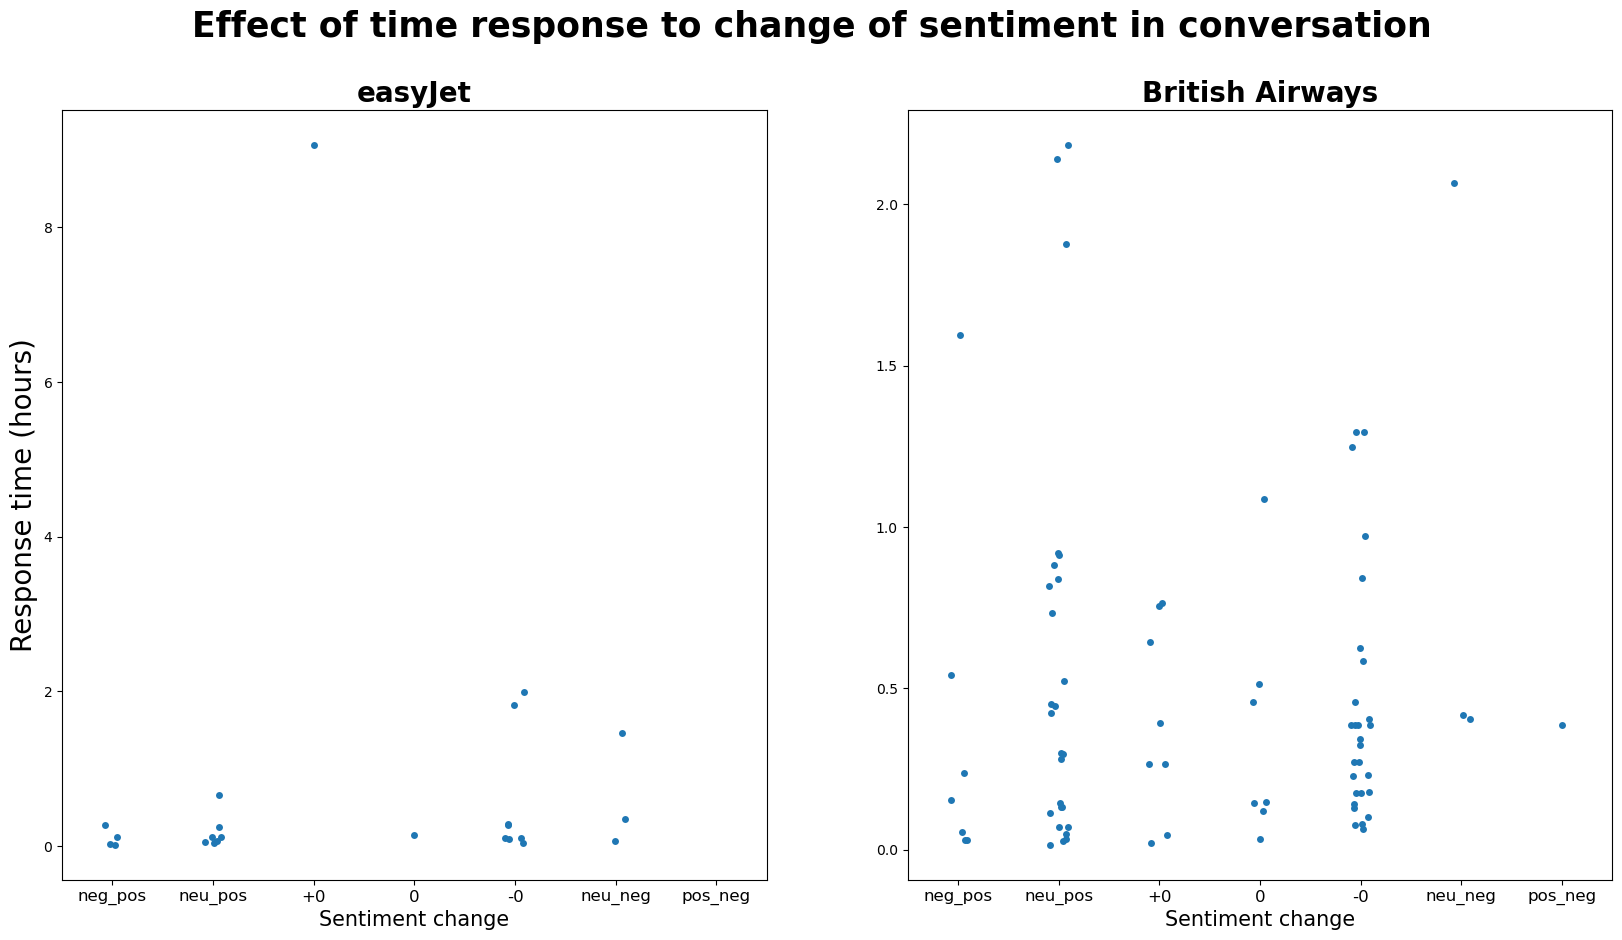

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10)) 

category_order = ["neg_pos", "neu_pos", "+0", "0", "-0", "neu_neg", "pos_neg"] ### delete this line if the visualisation does not work
sns.stripplot(data=cor_EJ_df, x="label_sentiment_diff", y="time_shift", order=category_order, ax=ax[0])
sns.stripplot(data=cor_BA_df, x="label_sentiment_diff", y="time_shift", order=category_order, ax=ax[1])

fig.suptitle('Effect of time response to change of sentiment in conversation', size = 25, weight = "bold")

ax[0].set_title("easyJet", size = 20, weight = "bold")
ax[1].set_title("British Airways", size = 20, weight = "bold")

ax[0].set_ylabel("Response time (hours)", size = 20)
ax[1].set_ylabel("")

ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)

ax[0].set_xlabel("Sentiment change", size=15)
ax[1].set_xlabel("Sentiment change", size=15);



In [50]:
# RESPONSE TIME FOR GIVEN TOPIC

special_id_lst = [] # list with all ids used for response anaalysis per topic, ids with conversation of lenght of 2
for key in conv_len.keys():
    if conv_len[key] == 2:
        special_id_lst.append(key)
        
special_df = pd.DataFrame()  

special_df = special_df.append(conv_df[conv_df['conv_id'].isin(special_id_lst)])

c_first_spl = [] # list with converstion ids where company starts 
u_first_spl = [] # list with converstion ids where user starts, in further analysis we only need this value

for index, rows in special_df[special_df['time_taken'] == 0].iterrows():
    if rows['user_id'] in list(avia_companies.values()):
        c_first_spl.append(rows['conv_id'])
    else:
        u_first_spl.append(rows['conv_id'])

## Spliting and preparing data for response time analysis per topic
userf_resp_df = pd.DataFrame()
compf_resp_df = pd.DataFrame()
special_resp_df = pd.DataFrame()

special_resp_df = special_resp_df.append(special_df[special_df['conv_id'].isin(u_first_spl)])
userf_resp_df = userf_resp_df.append(used_df[used_df['conv_id'].isin(u_first)])
compf_resp_df = compf_resp_df.append(used_df[used_df['conv_id'].isin(c_first)])

### Getting the data of special case where conversation is of len 2 (also user starts the conversation)
special_resp_df['time_shift'] = special_resp_df['time_taken'].shift(-1)
special_resp_df = special_resp_df[special_resp_df['time_taken'] == 0]
resp_user_s = special_resp_df

### Getting the data where company starts the conversation (we need only first message from the user)
compf_resp_df = compf_resp_df.set_index('conv_id')
compf_resp_df['time_shift'] = compf_resp_df['time_taken'].shift(-1)
indexes_compf_resp = compf_resp_df.index.unique().tolist()

resp_user_c = pd.DataFrame()

for index in indexes_compf_resp:
    resp_user_c = resp_user_c.append(compf_resp_df.loc[index].iloc[[1]])

resp_user_c = resp_user_c.reset_index()
# resp_user_c = resp_user_c.merge(replies, on='tweet_id', how='left')
# resp_user_c = resp_user_c.drop(['reply_to_status_id'], axis=1)

### Getting the data where user starts the conversation (we need only first message from the user)
userf_resp_df['time_shift'] = userf_resp_df['time_taken'].shift(-1)
# erf_resp_df = userf_resp_df.merge(replies, on='tweet_id', how='left')
# erf_resp_df = userf_resp_df.drop(['reply_to_status_id'], axis=1)
# erf_resp_df['reply_to_user_id'] = userf_resp_df['reply_to_user_id'].shift(-2)
userf_resp_df = userf_resp_df[userf_resp_df['time_taken']== 0]

resp_user_u = userf_resp_df

### Connecting three data frames into data frame used for topic analysis
merged_topic_df = pd.concat([resp_user_c, resp_user_u, resp_user_s ]) # it is not merging but we call this data frame for consitency reasosns

merged_topic_df['reply_to_label'] = merged_topic_df['for_airline_id'].apply(getting_company)
merged_topic_df['topic'] = merged_topic_df['text'].apply(lambda row: define_topic(row))
merged_topic_df = merged_topic_df
merged_topic_df = merged_topic_df.dropna(subset=['topic'])
topic_company_df = merged_topic_df.set_index('reply_to_label')
easyJet_topic_df = topic_company_df.loc['easyJet'].reset_index()


British_Airways_topic_df = topic_company_df.loc['British_Airways'].reset_index()



### Hypothesis testing if there is statistical difference between response time per topic
topic_EJ = easyJet_topic_df.groupby(['topic'])[['time_shift']].mean() # tells us about mean response time per topic
topic_EJ['time_shift'] = topic_EJ['time_shift'].apply(lambda x: x/3600000)
topic_EJ = topic_EJ.reset_index()

topic_BA = British_Airways_topic_df.groupby(['topic'])[['time_shift']].mean() # tells us about mean response time per topic
topic_BA['time_shift'] = topic_BA['time_shift'].apply(lambda x: x/3600000)
topic_BA = topic_BA.reset_index()

data_size_ej = easyJet_topic_df.groupby(['topic'])[['time_shift']].count() # shows the number of mentions per given topic 
                                                                           # for easyJet

data_size_ba = British_Airways_topic_df.groupby(['topic'])[['time_shift']].count() # shows the number of mentions per  
                                                                                   # given topic for BritishAirways

q1 = easyJet_topic_df["time_shift"].quantile(0.8) # limitting outliers for viusalisations
filter_e = easyJet_topic_df[easyJet_topic_df["time_shift"] < q1]
filter_e['time_shift'] = filter_e['time_shift'].apply(lambda x: x/3600000)

q2 = British_Airways_topic_df["time_shift"].quantile(0.8) # limitting outliers for viusalisations
filter_b = British_Airways_topic_df[British_Airways_topic_df["time_shift"] < q2]
filter_b['time_shift'] = filter_b['time_shift'].apply(lambda x: x/3600000)


/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/4122342456.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  special_df = special_df.append(conv_df[conv_df['conv_id'].isin(special_id_lst)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/4122342456.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  special_resp_df = special_resp_df.append(special_df[special_df['conv_id'].isin(u_first_spl)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/4122342456.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  userf_resp_df = userf_resp_df.append(used_df[used_df['conv_id'].isin(u_first)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/4122342456.py:28: FutureWa

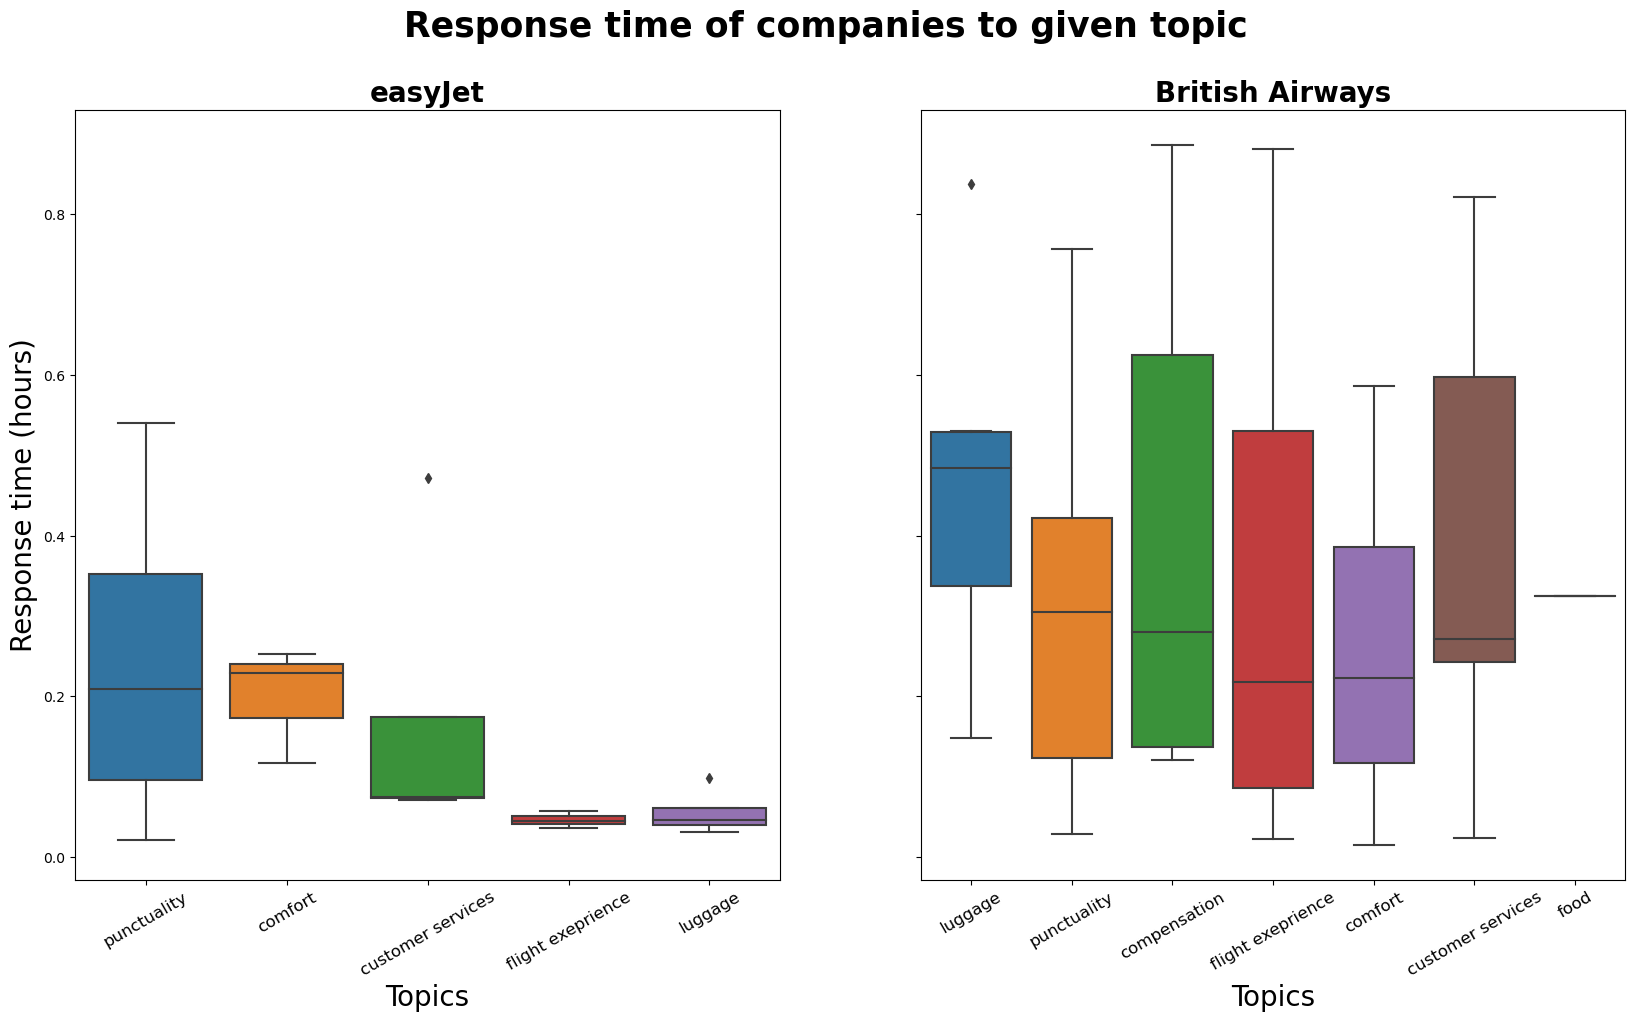

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey = True) ### prototype

sns.boxplot(data= filter_e, x = 'topic', y='time_shift', ax = ax[0])
sns.boxplot(data= filter_b, x = 'topic', y='time_shift', ax = ax[1]);

fig.suptitle('Response time of companies to given topic', size = 25, weight = "bold")

ax[0].set_title("easyJet", size = 20, weight = "bold")
ax[1].set_title("British Airways", size = 20, weight = "bold")

ax[0].set_ylabel("Response time (hours)", size = 20)
ax[1].set_ylabel("")

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, size =12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, size =12)

ax[0].set_xlabel("Topics", size=20)
ax[1].set_xlabel("Topics", size=20);

In [52]:
# Hypothesis testing using welch t-test (variance is not equal)

### H0 : There is no difference in means of response time for chosen topic between easyJet and British Airways.
### H1 : There is difference in means of response time for chosen topic between easyJet and British Airways.

topics = ["punctuality", "luggage", "food", "flight exeprience", "customer services", "compensation", "comfort"]

hyp_testing_topics_df = hyp_testing(easyJet_topic_df, British_Airways_topic_df, topics, 0.8, 300)

hyp_testing_topics_df

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/3853752335.py:181: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_test_df = hyp_test_df.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_98724/3853752335.py:181: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_test_df = hyp_test_df.append(row, ignore_index=True)


KeyError: 'food'